# Transfert d'apprentissage en Deep Learning (Transfer learning)


Exemple de transfert learning avec pytorch
 

[REQUIREMENTS.txt](#requirements)

In [1]:
# --- Imports

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from urllib.request import urlretrieve
from skimage.io import imread
from zipfile import ZipFile
from pathlib import Path
import shutil

In [2]:
# --- télécharger les données
# https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/

file_name = 'Food-5K.zip'
url = f'ftp://datasets@mmspgdata.epfl.ch:ohsh9jah4T@tremplin.epfl.ch/FoodImage/{file_name}'
chemin, _ = urlretrieve(url, f'../tmp/{file_name}')

In [3]:
# --- extraire
chemin_extract = '../tmp/Food-5K'
Path(chemin_extract).mkdir(parents=True, exist_ok=True)

with ZipFile(chemin, 'r') as z:
    z.extractall(path=chemin_extract)

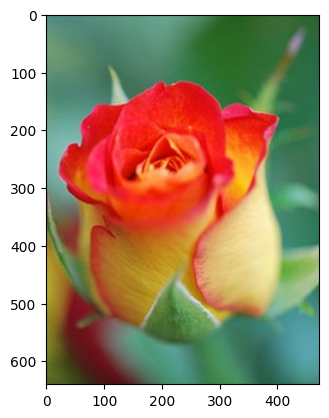

In [4]:
plt.imshow(imread(f'{chemin_extract}/training/0_808.jpg'))
plt.show()

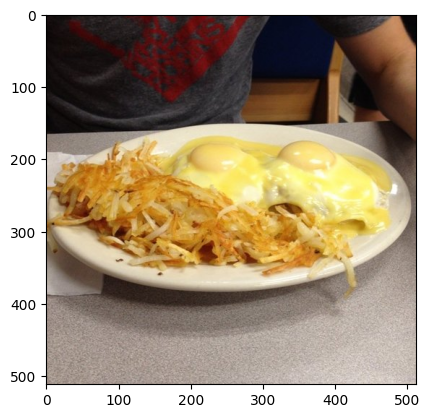

In [5]:
plt.imshow(imread(f'{chemin_extract}/training/1_808.jpg'))
plt.show()

Réorganisation des données  

Nous avons besoin d'une structure de fichiers comme ci-dessous pour entraîner notre modèle :  
```
├── tmp
│   ├──Food-5K
│   │   ├── ...
│   │   ├── data
│   │   │   ├── train
│   │   │   │   ├── nonfood
│   │   │   │   ├── food
│   │   │   ├── test
│   │   │   │   ├── nonfood
│   │   │   │   ├── food
```

In [6]:
# Création des dossiers
Path(f'{chemin_extract}/data/train/nonfood').mkdir(parents=True, exist_ok=True)
Path(f'{chemin_extract}/data/train/food').mkdir(parents=True, exist_ok=True)
Path(f'{chemin_extract}/data/test/nonfood').mkdir(parents=True, exist_ok=True)
Path(f'{chemin_extract}/data/test/food').mkdir(parents=True, exist_ok=True)

In [7]:
# Déplacer les fichiers
old_subfolders = ['training','validation']
new_subfolders = ['train','test']

for i in zip(old_subfolders, new_subfolders):
    nonfood_files = Path(f'{chemin_extract}').glob(f'{i[0]}/0*.jpg')
    food_files = Path(f'{chemin_extract}').glob(f'{i[0]}/1*.jpg')

    for j in nonfood_files:
        shutil.move(j, Path(f'{chemin_extract}/data/{i[1]}/nonfood/{j.name}'))
    
    for j in food_files:
        shutil.move(j, Path(f'{chemin_extract}/data/{i[1]}/food/{j.name}'))

In [8]:
# --- Transformations à appliquer

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# --- Création de l'import des données

train_dataset = datasets.ImageFolder(f'{chemin_extract}/data/train', transform=transform)
test_dataset = datasets.ImageFolder(f'{chemin_extract}/data/test', transform=transform)

In [10]:
# --- Data loader

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [11]:
# --- Instancier le modèle
model = models.vgg16(pretrained=True)

# geler les poids
for param in model.parameters():
    param.requires_grad = False

g:\Utilisateurs\Nelly\Travail_Perso\python-envs\torch-env310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\Utilisateurs\Nelly\Travail_Perso\python-envs\torch-env310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# --- Features du modèle

class VGGFeatures(nn.Module):
    def __init__(self, model):
        super(VGGFeatures, self).__init__()
        self.vgg = model
    
    def forward(self, X):
        out = self.vgg.features(X)
        out = self.vgg.avgpool(out)
        out = out.view(out.size(0), -1)
        return out

In [14]:
vggf = VGGFeatures(model)

In [15]:
# check dimension de sortie
out = vggf(torch.rand(1, 3, 224, 224))
out.shape

torch.Size([1, 25088])

In [16]:
ntrain = len(train_dataset)
ntest = len(test_dataset)
ntrain, ntest

(3000, 1000)

In [17]:
D = out.shape[1]
D

25088

In [18]:
# --- Initialiser des matrices vides
X_train = np.zeros((ntrain, D))
y_train = np.zeros((ntrain, 1))
X_test = np.zeros((ntest, D))
y_test = np.zeros((ntest, 1))

In [19]:
# --- GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

vggf.to(device)

cuda:0


VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [20]:
# --- Ajouter les données dans les matrices

# train
i = 0
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        output = vggf(inputs)

        size_of_batch = len(output)

        X_train[i:i + size_of_batch] = output.cpu().detach().numpy()
        y_train[i:i + size_of_batch] = targets.view(-1, 1).numpy()

        i += size_of_batch
        print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000


In [21]:
# test
i = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        output = vggf(inputs)

        size_of_batch = len(output)

        X_test[i:i + size_of_batch] = output.cpu().detach().numpy()
        y_test[i:i + size_of_batch] = targets.view(-1, 1).numpy()

        i += size_of_batch
        print(i)

128
256
384
512
640
768
896
1000


In [22]:
X_train.max(), X_train.min()

(53.995121002197266, 0.0)

In [23]:
# --- Standardisation

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [24]:
# Régression logistique
model_vf = nn.Linear(D, 1)

In [25]:
# --- GPU
model_vf.to(device)

Linear(in_features=25088, out_features=1, bias=True)

In [26]:
# --- jeu de données d'entraînement

train_dataset_2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train2.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32))
)

test_dataset_2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test2.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32))
)

In [27]:
# --- Data loaders

batch_size = 128
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset_2, batch_size=batch_size, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset_2, batch_size=batch_size, shuffle=False)

In [28]:
# --- Entraîner le modèle

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_vf.parameters())

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'''Epoch {it+1}/{epochs}\n-----------------
        Train Loss: {train_loss:.4f}
        Test Loss: {test_loss:.4f}
        Duration: {dt}
        ''')
    return train_losses, test_losses

In [29]:
# lancer la boucle d'entraînement
train_losses, test_losses = batch_gd(model_vf, criterion, optimizer, train_loader2, test_loader2, epochs=10)

Epoch 1/10
-----------------
        Train Loss: 0.1466
        Test Loss: 0.0854
        Duration: 0:00:00.711618
        
Epoch 2/10
-----------------
        Train Loss: 0.0173
        Test Loss: 0.0916
        Duration: 0:00:00.234766
        
Epoch 3/10
-----------------
        Train Loss: 0.0038
        Test Loss: 0.0856
        Duration: 0:00:00.216397
        
Epoch 4/10
-----------------
        Train Loss: 0.0024
        Test Loss: 0.0857
        Duration: 0:00:00.218002
        
Epoch 5/10
-----------------
        Train Loss: 0.0018
        Test Loss: 0.0863
        Duration: 0:00:00.219849
        
Epoch 6/10
-----------------
        Train Loss: 0.0014
        Test Loss: 0.0863
        Duration: 0:00:00.215415
        
Epoch 7/10
-----------------
        Train Loss: 0.0012
        Test Loss: 0.0869
        Duration: 0:00:00.219730
        
Epoch 8/10
-----------------
        Train Loss: 0.0010
        Test Loss: 0.0873
        Duration: 0:00:00.246389
        
Epoch 9/

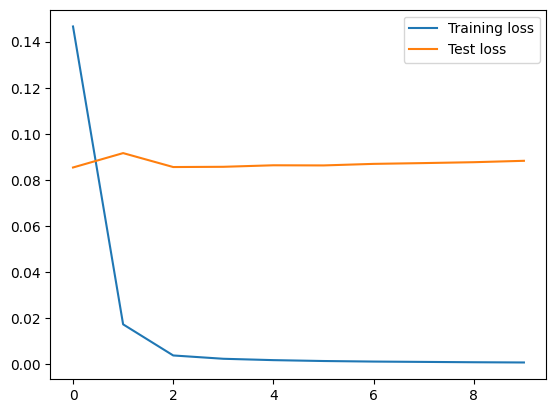

In [30]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [31]:
# Calcul de l'accuracy

model.eval()

# train
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader2:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model_vf(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct/n_total

# test
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader2:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model_vf(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_accuracy = n_correct/n_total

print(f'Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')

Train accuracy: 1.0000, Test accuracy: 0.9760


## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```